In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import time
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
import random

import matplotlib.cm as cm
import matplotlib.colors as mcolors 
import time
import matplotlib as mpl
from matplotlib.patches import Polygon
import plot_reg_downstream

sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

pd.set_option('display.max_rows', 100)
sc.set_figure_params(figsize=(20, 4))
plt.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'NimbusSanL'

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [2]:
de_summary_stats = pd.read_csv('../../metadata/suppl_tables/DE_stats.suppl_table.csv', index_col=0)
adata_de = sc.read_h5ad('../../../../3_expts/processed_data/CD4i_final/DE_results_all_confounders/CD4i_final.merged_DE_results_corrected.h5ad', backed='r')
cluster_nde75_ntotal50 = pd.read_csv('../../metadata/clustering_results.csv', index_col=0)
corr_df_all = pd.read_csv('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_gene_across_condition_correlation_matrix.csv', index_col=0)

## Plot all individual clusters

In [3]:
for cl in cluster_nde75_ntotal50['hdbscan'].unique():
    thres = 0.6
    
    np.random.seed(100)
    genelist = cluster_nde75_ntotal50[cluster_nde75_ntotal50['hdbscan']==cl]['target_contrast_corrected'].unique().tolist()
    genelist = set(genelist) & set(adata_de.obs.target_contrast_corrected.value_counts()[adata_de.obs.target_contrast_corrected.value_counts()==3].index)
    regulator = list(genelist)
    
    # Reorder regulator based on hierarchical clustering of regulators in main conditions
    # For each cluster, get regulator member list
    main_condition = cluster_nde75_ntotal50[cluster_nde75_ntotal50['hdbscan']==cl]['culture_condition'].value_counts().index[0]
    regulator_main_condition = [item+'_'+main_condition for item in regulator]
    
    # Get reordered downstream genes based on DE effect of main condition
    clustermap = sns.clustermap(corr_df_all.loc[regulator_main_condition, regulator_main_condition], 
                                method='ward', 
                                metric='euclidean')
    xticklabel_indices = clustermap.dendrogram_col.reordered_ind
    plt.close(clustermap.fig)
    regulator_reordered = np.array(regulator)[xticklabel_indices]
    
    target_names_rest = adata_de[adata_de.obs['culture_condition']=='Rest'].obs['target_contrast_corrected']
    isin_mask = np.isin(regulator_reordered, target_names_rest)
    regulator_rest = regulator_reordered[isin_mask]
    regulator_rest = [item+'_Rest' for item in regulator_rest]
    target_names_stim8hr = adata_de[adata_de.obs['culture_condition']=='Stim8hr'].obs['target_contrast_corrected']
    isin_mask = np.isin(regulator_reordered, target_names_stim8hr)
    regulator_stim8hr = regulator_reordered[isin_mask]
    regulator_stim8hr = [item+'_Stim8hr' for item in regulator_stim8hr]
    target_names_stim48hr = adata_de[adata_de.obs['culture_condition']=='Stim48hr'].obs['target_contrast_corrected']
    isin_mask = np.isin(regulator_reordered, target_names_stim48hr)
    regulator_stim48hr = regulator_reordered[isin_mask]
    regulator_stim48hr = [item+'_Stim48hr' for item in regulator_stim48hr]
    regulator_all = np.concatenate([regulator_rest, regulator_stim8hr, regulator_stim48hr])
    
    # Create figure with space for color bars
    fig = plt.figure(figsize=(6, 6), constrained_layout=True)
    gs = fig.add_gridspec(2, 2, width_ratios=[0.075, 1], height_ratios=[0.075, 1],
                          hspace=0.02, wspace=0.01)
    
    ax_heatmap = fig.add_subplot(gs[1, 1])
    ax_col_colors = fig.add_subplot(gs[0, 1], sharex=ax_heatmap)
    ax_row_colors = fig.add_subplot(gs[1, 0], sharey=ax_heatmap)
    
    # Create heatmap
    sns.heatmap(corr_df_all.loc[regulator_all, regulator_all],
                vmin=-thres, vmax=thres, cmap='BrBG_r',
                cbar=False, xticklabels=False, yticklabels=False,
                square=True, ax=ax_heatmap)
    
    # Create color arrays - assign categories as numbers
    n = len(regulator_all)
    condition_list = np.array([item.split('_')[1] for item in regulator_all])
    col_categories = np.empty(n)
    col_categories[condition_list=='Rest'] = 0
    col_categories[condition_list=='Stim8hr'] = 0.5
    col_categories[condition_list=='Stim48hr'] = 1
    row_categories = col_categories
    
    # Create a custom colormap for the categories
    colors = ['#527ca0', '#c35f5a', '#dea26b']  # Add more colors as needed
    cmap = mcolors.ListedColormap(colors)
    
    # Plot color bars with proper extent to align with heatmap
    ax_col_colors.imshow([col_categories], aspect='auto', cmap=cmap, 
                         extent=[0, n, 0, 1])
    ax_col_colors.set_xlim(0, n)
    ax_col_colors.axis('off')
    
    ax_row_colors.imshow([[c] for c in row_categories], aspect='auto', cmap=cmap,
                         extent=[0, 1, n, 0])
    ax_row_colors.set_ylim(n, 0)
    ax_row_colors.axis('off')
    
    plt.savefig('./results/cluster_plots/cluster'+str(cl)+'.png', dpi=600)
    plt.close()

In [5]:
for cl in cluster_nde75_ntotal50['hdbscan'].unique():
    thres = 0.4
    
    np.random.seed(100)
    genelist = cluster_nde75_ntotal50[cluster_nde75_ntotal50['hdbscan']==cl]['target_contrast_corrected'].unique().tolist()
    genelist = set(genelist) & set(adata_de.obs.target_contrast_corrected.value_counts()[adata_de.obs.target_contrast_corrected.value_counts()==3].index)
    regulator = list(genelist)
    
    # Reorder regulator based on hierarchical clustering of regulators in main conditions
    # For each cluster, get regulator member list
    main_condition = cluster_nde75_ntotal50[cluster_nde75_ntotal50['hdbscan']==cl]['culture_condition'].value_counts().index[0]
    regulator_main_condition = [item+'_'+main_condition for item in regulator]
    
    # Get reordered downstream genes based on DE effect of main condition
    clustermap = sns.clustermap(corr_df_all.loc[regulator_main_condition, regulator_main_condition], 
                                method='ward', 
                                metric='euclidean')
    xticklabel_indices = clustermap.dendrogram_col.reordered_ind
    plt.close(clustermap.fig)
    regulator_reordered = np.array(regulator)[xticklabel_indices]
    
    target_names_rest = adata_de[adata_de.obs['culture_condition']=='Rest'].obs['target_contrast_corrected']
    isin_mask = np.isin(regulator_reordered, target_names_rest)
    regulator_rest = regulator_reordered[isin_mask]
    regulator_rest = [item+'_Rest' for item in regulator_rest]
    target_names_stim8hr = adata_de[adata_de.obs['culture_condition']=='Stim8hr'].obs['target_contrast_corrected']
    isin_mask = np.isin(regulator_reordered, target_names_stim8hr)
    regulator_stim8hr = regulator_reordered[isin_mask]
    regulator_stim8hr = [item+'_Stim8hr' for item in regulator_stim8hr]
    target_names_stim48hr = adata_de[adata_de.obs['culture_condition']=='Stim48hr'].obs['target_contrast_corrected']
    isin_mask = np.isin(regulator_reordered, target_names_stim48hr)
    regulator_stim48hr = regulator_reordered[isin_mask]
    regulator_stim48hr = [item+'_Stim48hr' for item in regulator_stim48hr]
    regulator_all = np.concatenate([regulator_rest, regulator_stim8hr, regulator_stim48hr])
    
    # Create figure with space for color bars
    fig = plt.figure(figsize=(6, 6), constrained_layout=True)
    gs = fig.add_gridspec(2, 2, width_ratios=[0.075, 1], height_ratios=[0.075, 1],
                          hspace=0.02, wspace=0.01)
    
    ax_heatmap = fig.add_subplot(gs[1, 1])
    ax_col_colors = fig.add_subplot(gs[0, 1], sharex=ax_heatmap)
    ax_row_colors = fig.add_subplot(gs[1, 0], sharey=ax_heatmap)
    
    # Create heatmap
    sns.heatmap(corr_df_all.loc[regulator_all, regulator_all],
                vmin=-thres, vmax=thres, cmap='BrBG_r',
                cbar=False, xticklabels=False, yticklabels=False,
                square=True, ax=ax_heatmap)
    
    # Create color arrays - assign categories as numbers
    n = len(regulator_all)
    condition_list = np.array([item.split('_')[1] for item in regulator_all])
    col_categories = np.empty(n)
    col_categories[condition_list=='Rest'] = 0
    col_categories[condition_list=='Stim8hr'] = 0.5
    col_categories[condition_list=='Stim48hr'] = 1
    row_categories = col_categories
    
    # Create a custom colormap for the categories
    colors = ['#527ca0', '#c35f5a', '#dea26b']  # Add more colors as needed
    cmap = mcolors.ListedColormap(colors)
    
    # Plot color bars with proper extent to align with heatmap
    ax_col_colors.imshow([col_categories], aspect='auto', cmap=cmap, 
                         extent=[0, n, 0, 1])
    ax_col_colors.set_xlim(0, n)
    ax_col_colors.axis('off')
    
    ax_row_colors.imshow([[c] for c in row_categories], aspect='auto', cmap=cmap,
                         extent=[0, 1, n, 0])
    ax_row_colors.set_ylim(n, 0)
    ax_row_colors.axis('off')
    
    plt.savefig('./results/cluster_plots/cluster'+str(cl)+'_'+str(thres)+'.png', dpi=600)
    plt.close()

## Plot colormap

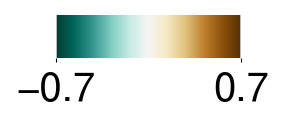

In [3]:
thres = 0.7
orientation = 'bottom'
cmap = sns.color_palette("BrBG_r", as_cmap=True)
norm = mpl.colors.Normalize(vmin=-thres, vmax=thres)

# Create small horizontal figure
fig, ax = plt.subplots(figsize=(2, 1))

# Draw the colorbar
cb = mpl.colorbar.ColorbarBase(
    ax,
    cmap=cmap,
    norm=norm,
    orientation='horizontal'
)

# Remove outline and tidy style
cb.ax.tick_params(labelsize=18, width=0.5, length=2)
cb.set_ticks([-thres, thres])
#cb.set_ticklabels(['0.1', '0.5'])

cb.ax.xaxis.set_ticks_position(orientation)

# Adjust layout
plt.subplots_adjust(left=0.25, right=0.95, top=0.7, bottom=0.45)
plt.tight_layout()
plt.savefig('./results/colorbar_'+str(thres)+orientation+'.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

## Print schematics

In [ ]:
adata_cluster = sc.read_h5ad('../../../../3_expts/processed_data/analysis_largefiles/adata_de_nde75ntotal50_varfiltered_simple.h5ad')
adata_final = sc.read_h5ad('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering.h5ad', backed=True)

In [10]:
adata_de_tmp = adata_cluster.copy()
adata_transposed = adata_de_tmp.T

sc.pp.scale(adata_transposed)
sc.tl.pca(adata_transposed, n_comps=50)
sc.pp.neighbors(adata_transposed, n_pcs=50, n_neighbors=63, random_state=42)
sc.tl.leiden(adata_transposed, resolution=1, random_state=42)


sc.pp.scale(adata_de_tmp)
sc.tl.pca(adata_de_tmp, n_comps=50)
sc.pp.neighbors(adata_de_tmp, n_pcs=50, n_neighbors=63, random_state=42)
sc.tl.leiden(adata_de_tmp, resolution=1, random_state=42)

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():
python(43599) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_43345/2201469354.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden

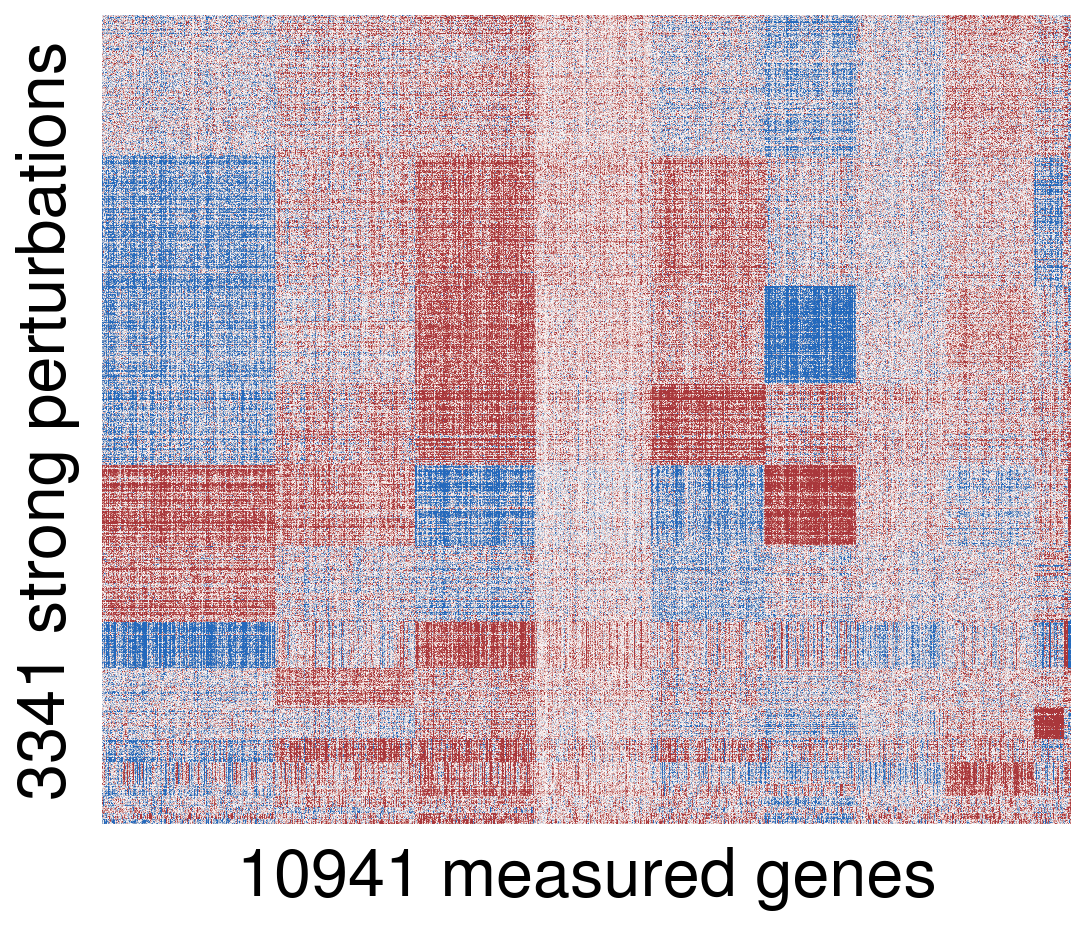

In [15]:
from scipy.ndimage import gaussian_filter
heatmap_data = gaussian_filter(adata_cluster[adata_de_tmp.obs.sort_values(by='leiden').index,
    adata_transposed.obs.sort_values(by='leiden').index].layers['zscore'], sigma=0.8)

fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(heatmap_data, cmap='vlag', vmin=-1, vmax=1, xticklabels=False, yticklabels=False, cbar=False, ax=ax, rasterized=True)
plt.xlabel(str(adata_cluster.shape[1])+' measured genes', fontsize=30, labelpad=10)
plt.ylabel(str(adata_cluster.shape[0])+' strong perturbations', fontsize=30, labelpad=10)
plt.tight_layout()
plt.savefig('./results/adata_de_filter_heatmap_for_schematics.pdf', dpi=600, bbox_inches='tight', pad_inches=0)

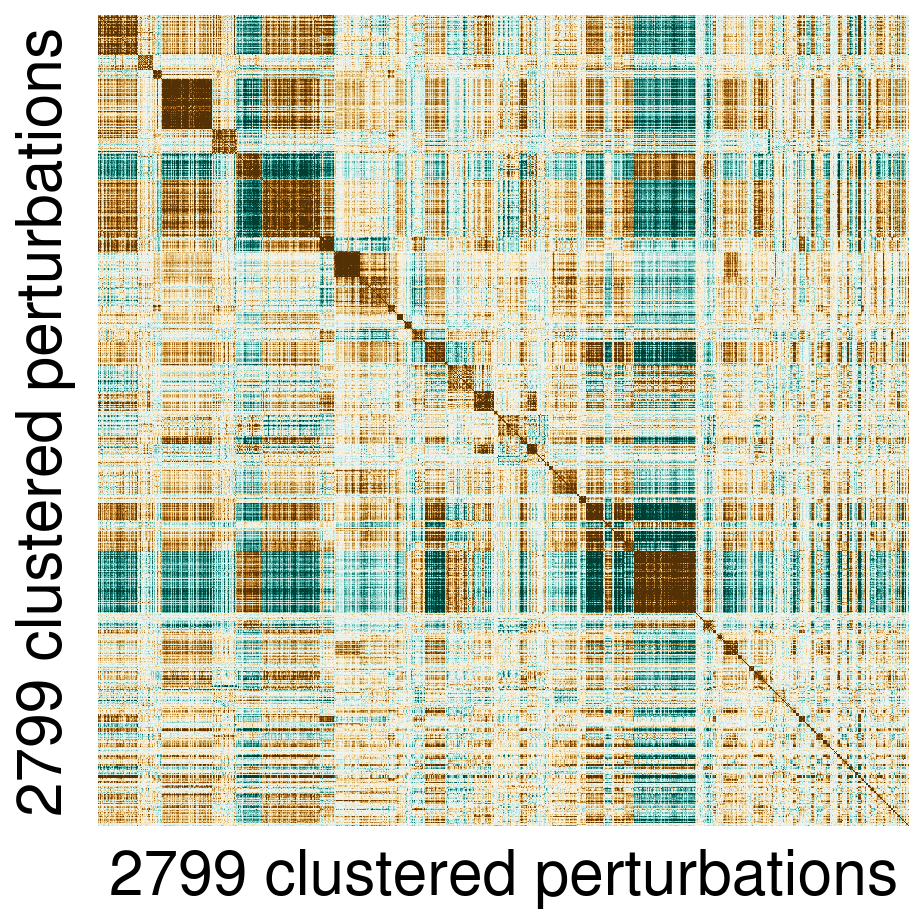

In [16]:
fig, ax = plt.subplots(figsize=(6,6))
data = np.empty([0,adata_final.shape[1]])
ind = []
for i in adata_final.obs['hdbscan'].unique():
    if i != -1:
        data = np.concatenate([data, adata_final[adata_final.obs['hdbscan']==i].layers['masked_zscore']])
        list1 = adata_final[adata_final.obs['hdbscan']==i].obs.target_contrast_gene_name_corrected.values.tolist()
        list2 = adata_final[adata_final.obs['hdbscan']==i].obs.culture_condition.values.tolist()
        ind = ind +[f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]

df = pd.DataFrame(data=data, index=ind, columns=adata_final.var_names)
X = df.values
row_means = X.mean(axis=1, keepdims=True)
row_stds = X.std(axis=1, keepdims=True)
Z = (X - row_means) / row_stds
R_unscaled = Z @ Z.T
R = R_unscaled / (X.shape[1])
df_corr = pd.DataFrame(R, index=df.index.tolist(), columns=df.index.tolist())
sns.heatmap(df_corr, vmin=-0.3, vmax=0.3, xticklabels=False, yticklabels=False, cmap='BrBG_r', cbar=False, ax=ax, rasterized=True)
ax.set_xlabel(str(len(data))+' clustered perturbations', fontsize=28, labelpad=10)
ax.set_ylabel(str(len(data))+' clustered perturbations', fontsize=28, labelpad=10)
plt.tight_layout()
plt.savefig('./results/adata_final_cluster_heatmap_for_schematics.pdf', dpi=600, bbox_inches='tight', pad_inches=0)